# Ground roll attenuation: Deighan and Watts (1997)
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](http://www.ausargeo.com))*

## Summary
Deighan and Watts proposed using wavelets to attenuate ground roll. I wrote a quick and simple implementation using PyWavelets (which does not contain the wavelet recommended by the authors) and applied it to one shot record of real 2D land data. I did not get good results.

## Introduction
One of the most cited papers on ground roll attenuation is [this one](http://library.seg.org/doi/abs/10.1190/1.1444290) by Deighan and Watts. In this notebook, I am going to have a quick go at implementing it in Python.

Wavelets used to be a very hot topic - comparable to the "machine learning" of the late 1990s and early 2000s. There was a time when everyone was inventing their own wavelet. From what I see, it seems to have fizzled out quite a bit these days. It was in its heyday when Deighan and Watts wrote their paper, though, so it is not surprising that they decided to apply wavelets to the problem of ground roll attenuation.

The idea is quite simple:
* Ground roll tends to be of lower frequency than most of the data we are interested in, so one way to attenuate it is with a high-pass filter
* A high-pass filter applied to the whole trace will, however, remove some data we are interested in
* Ground roll travels slowly and so only affects the data after a certain offset-dependent time
* Wavelets allow filtering in both time and frequency
* Let's therefore use wavelets to only apply the high-pass filter to the times sections of the trace affected by ground roll, so we don't damage the earlier arrivals
    
It also sounds pretty simple to implement. We just need to apply a wavelet transform to each trace, zero-out the wavelet components for the low frequencies after the time that ground roll starts affecting the trace, and then apply the inverse wavelet transform.

There are some complications, however. One is that the dominant Python wavelet library, [PyWavelets](https://pywavelets.readthedocs.io/), does not contain the Battle-Lemarié wavelet that Deighan and Watts used. They do mention the Daubechies 12 wavelet quite a few times, though, which PyWavelets does have, so let's try that instead.

A second complication is that the discrete wavelet transform decimates the signal at each scale. At higher scales (lower frequencies), each wavelet coefficient therefore corresponds to a larger time section of the signal. This means that we have lower time precision at high scales and so zeroing-out coefficients at these scales may affect parts of the signal that we don't want it to.

With those complications noted, let's move on to the implementation.

## Implementation
I separated the method into two steps: one to filter a single trace, and one to filter a whole shot record (which calls the former for each trace). The only non-trivial part is deciding which wavelet coefficients to set to zero. At the levels affected (the ones corresponding to low frequencies), I want to zero the coefficients for times after the trace has been affected by ground roll. I therefore need to decide what that time is, using the offset of the trace and the ground roll speed. I then calculate what fraction this time is of the whole trace length. As the wavelet coefficients at a particular level correspond to successive chunks of time, if I have calculated that the second half of the trace is affected by ground roll, then I need to zero the second half of the array of wavelet coefficients. To be sure that I don't miss any of the ground roll, I round down in this calculation (by truncating to an integer), although this means some time before the ground roll could also be affected.

In [71]:
import pywt
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
DEFAULT_WAVELET = 'db12'
DEFAULT_LEVEL = 4

def filter_shot_record(shot_record, dt, shot_start_time,
                       ground_roll_speed, offsets,
                       wavelet=DEFAULT_WAVELET, level=DEFAULT_LEVEL):
    """Filter a shot record.
    
    Arguments:
        shot_record: a 2D numpy array (num traces, num samples)
        dt: a float containing the time interval between samples
        shot_start_time: the time at which the shot starts in the
                         shot record (often 0.0)
        ground_roll_speed: the speed at which the ground roll travels
                           in the units of offsets / dt
        offsets: a 1D numpy array with one entry for each trace
                 giving its absolute offset from the source
        wavelet: a string with the name of one of PyWavelets's
                 available wavelet types
        level: the scale level to filter to. All scales containing
               lower frequencies than this will be set to zero
               in the ground roll region
               
    Returns:
        the filtered shot record as a 2D numpy array of the same
        size as the input
    """
    assert(shot_record.ndim == 2)
    assert(offsets.ndim == 1)
    assert(offsets.shape[0] == shot_record.shape[0])
    filtered_shot_record = np.zeros_like(shot_record)
    for trace_idx, trace in enumerate(shot_record):
        ground_roll_start_time = (shot_start_time
                                  + offsets[trace_idx] / ground_roll_speed)
        # the fraction of the trace not containing ground roll
        start_fraction = ground_roll_start_time / (len(trace) * dt)
        filtered_shot_record[trace_idx, :] = \
                filter_trace(trace, start_fraction, wavelet, level)
    return filtered_shot_record


def filter_trace(trace, start_fraction=0.0, wavelet=DEFAULT_WAVELET,
                 level=DEFAULT_LEVEL):
    """Filter a single trace.
    
    Arguments:
        trace: a 1D numpy array containing the samples of a single trace
        start_fraction: a float containing the fraction of the trace
                        unaffected by ground roll
        wavelet: a string containing the PyWavelets wavelet to use
        level: the scale level to filter to. All scales containing
               lower frequencies than this will be set to zero
               in the ground roll region
               
    Returns:
        a 1D numpy array of the same size as the input trace
        containing the filtered trace"""
    coeffs = pywt.wavedec(trace, wavelet)
    # the coefficients are arranged from lowest frequency
    # to highest, so leave the last 'level' (an integer) ones
    # (the highest frequencies)
    # untouched and zero the others in the ground-roll region
    for coeff_idx in range(len(coeffs) - level):
        start_idx = int(start_fraction * len(coeffs[coeff_idx]))
        coeffs[coeff_idx][start_idx:] = 0
    filtered_trace = pywt.waverec(coeffs, wavelet)
    return filtered_trace

## Results
Now that the code is ready, let's apply it to some real data. I have chosen some [2D land data from Alaska](http://wiki.seg.org/wiki/Alaska_2D_land_line_31-81) provided by the USGS. I followed Karl Schleicher's [processing flow](http://s3.amazonaws.com/open.source.geoscience/open_data/alaska/alaska31-81.tar.gz) to remove some bad traces, and then converted the data to NetCDF format using my [netcdf_segy](https://github.com/ar4/netcdf_segy/blob/master/notebooks/netcdf_segy.ipynb) tool.

In the next few cells below, I load this NetCDF file using xarray, select one shot record, and plot it.

In [73]:
d = xr.open_dataset('/home/alanr/Downloads/alaska/alaska31-81/allshots.nc')

In [74]:
shotrecord = d.Samples.isel(FieldRecord=1)

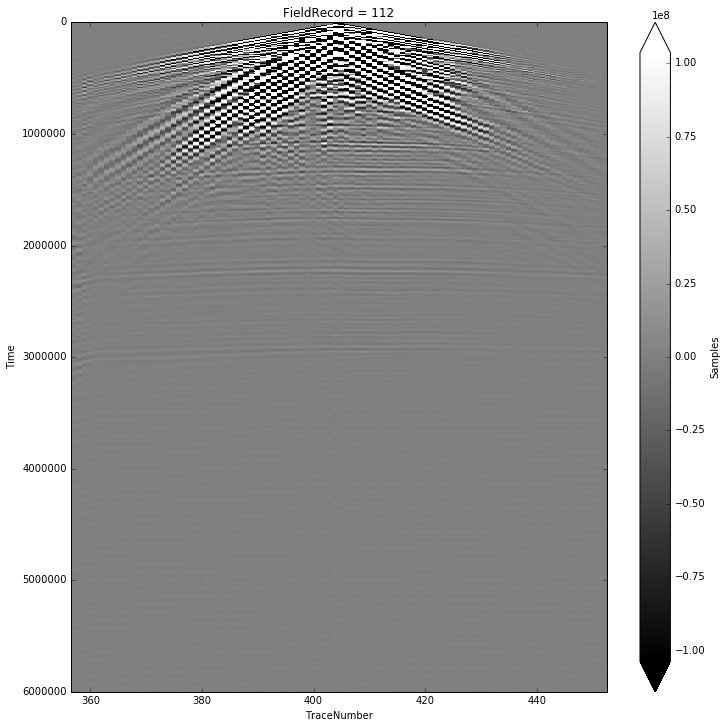

In [75]:
shotrecord.T.plot(robust=True, yincrease=False, cmap='gray', figsize=(12,12))

There's certainly plenty of ground roll in that shot record. (In case you aren't very familiar with ground roll, it is the collection of arrivals sloping away from the source location at a slightly greater dip than the direct arrival, obscuring many reflection arrivals.)

Let's first try-out the method on a single trace. To make it easier to see the ground roll, I choose a trace near the edge of the shot record, where the ground roll arrives quite a bit later than the direct arrival. I then filter this trace using the Deighan and Watts method with two different maximum levels (only scales below these levels will be kept), and plot the original and the two filtered traces.

In [76]:
trace = shotrecord.isel(TraceNumber=15)

In [77]:
filtered_trace3 = filter_trace(trace, level=3)
filtered_trace4 = filter_trace(trace, level=4)

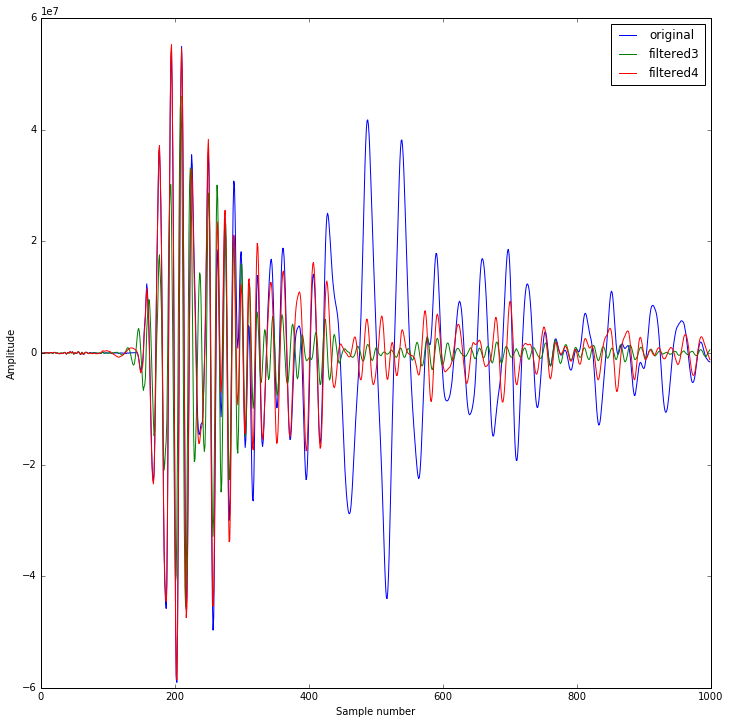

In [78]:
plt.figure(figsize=(12,12))
plt.plot(trace[:1000], label='original')
plt.plot(filtered_trace3[:1000], label='filtered3')
plt.plot(filtered_trace4[:1000], label='filtered4')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.legend();

The method seems to have worked quite well. The early arrivals (up to about sample 300 on the plot), which we do not wish to change with this method, look fairly similar among all of the plotted traces. The low frequency, high amplitude arrivals after this, the ground roll, has been greatly attenuated in the filtered traces. Filtering to level 3 (which removes more frequencies than level 4) removes more of the signal, as expected, but is it too much?

Now let's try filtering a whole shot record. To do this, we need the offset of each trace in the record, which we can get from the NetCDF file. We also need an estimate of the ground roll speed. Looking at the shot record plot above, we see that at the first trace in the record, the ground roll starts arriving at about 1 second (1000000 microseconds). We can thus estimate the ground roll speed as the offset of the first trace (its distance from the source) divided by 1 second.

In [79]:
offset = d.offset.isel(FieldRecord=1).values

In [80]:
ground_roll_speed = np.abs(offset[0])/1

In [81]:
ground_roll_speed

5225.0

That's a fairly high number for ground roll speed. I assume that the offset values in this survey must be given in feet rather than meters.

We now have everything that we need to apply the method to a shot record. I will put the result into an array in our xarray dataset, so I need to specify that its dimensions are trace number and time. The time interval in this dataset is 2 ms (2000e-6 s), and I will estimate the shot start time as 100 ms.

Since it wasn't clear in the previous test whether level 3 or 4 was most appropriate, let's run it with both again.

The original shot record is plotted again below, for ease of comparison, and I have zoomed-in on the beginning of the record and applied some interpolation to make it easier to examine. The results of the method are plotted next.

In [82]:
d['Filtered_Samples3']=(('TraceNumber', 'Time'),
                       filter_shot_record(shotrecord.values, 2000e-6, 100000e-6,
                                          ground_roll_speed, np.abs(offset), level=3))
d['Filtered_Samples4']=(('TraceNumber', 'Time'),
                       filter_shot_record(shotrecord.values, 2000e-6, 100000e-6,
                                          ground_roll_speed, np.abs(offset), level=4))

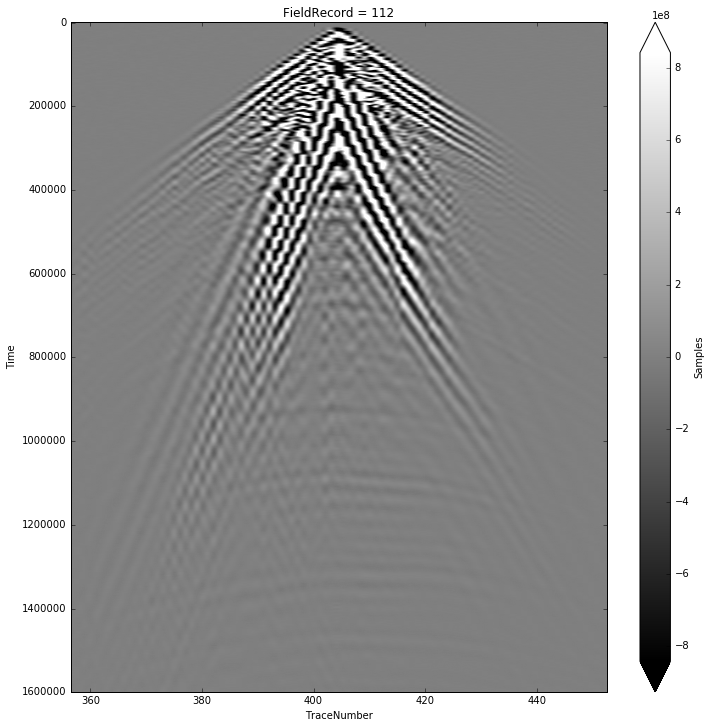

In [83]:
shotrecord.isel(Time=slice(0,800)).T.plot.imshow(cmap='gray', robust=True,
                                                 yincrease=False, figsize=(12,12),
                                                 interpolation='lanczos')

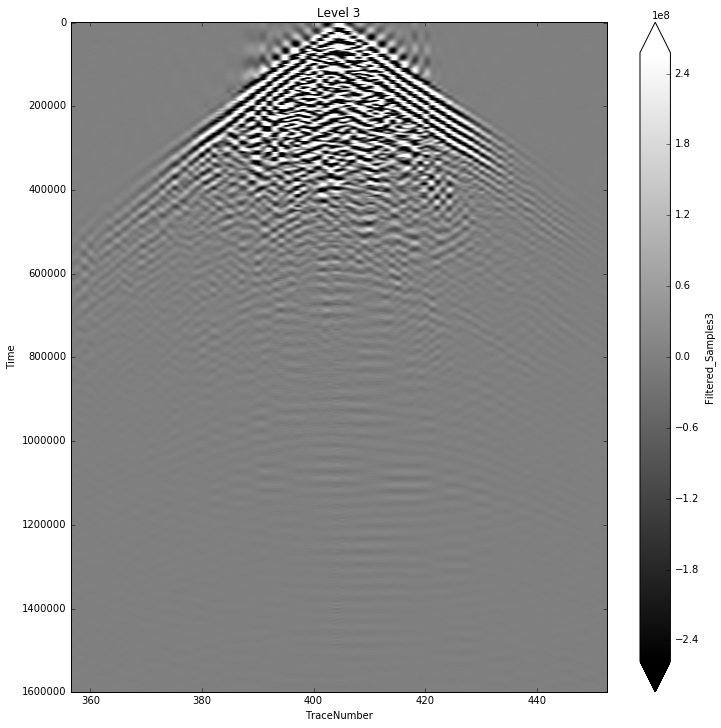

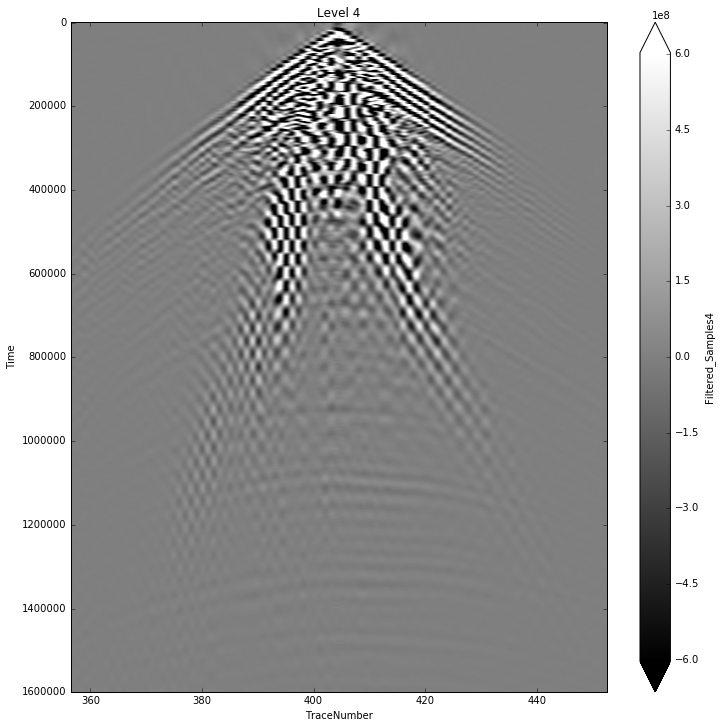

In [84]:
d['Filtered_Samples3'].isel(Time=slice(0,800)).T.plot.imshow(cmap='gray', robust=True,
                                                            yincrease=False, figsize=(12,12),
                                                            interpolation='lanczos')
plt.title('Level 3');
plt.figure();
d['Filtered_Samples4'].isel(Time=slice(0,800)).T.plot.imshow(cmap='gray', robust=True,
                                                            yincrease=False, figsize=(12,12),
                                                            interpolation='lanczos')
plt.title('Level 4');

Although the ground roll certainly seems to have been removed in the level 3 result, it looks like the method might have also done some other damage. One obvious effect is the newly introduced noise before the direct arrival near the source. I suspect that this is due to the poor time selectivity of wavelets at high scales. More worrying is that the reflection arrivals in the lower half of the plot also seem to have been affected.

The level 4 result isn't significantly affected by either of these problems, but also isn't very effective at removing the ground roll.

## Conclusion
Although it was simple to create my quick implementation of the method, I wasn't able to use the wavelet suggested by the author's (because it is not contained in PyWavelets), and I am not impressed by the results. I suspect that a useful implementation requires quite a bit more work. If you have suggestions for improvement, please [let me know](mailto:alan@ausargeo.com)!